In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nilearn 
from nilearn import datasets
from nilearn import connectome
import nibabel as nib
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import seaborn as sns
from tqdm.notebook import tqdm
import multinetx as mx
from sklearn.model_selection import train_test_split
import bct 
from scipy import stats
import json
import os

sns.set_style('darkgrid')

In [2]:
# load autism supra-adjacency matrix
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas["maps"]
labels = atlas["labels"]
num_ROIs = len(labels)

In [3]:
# Loading json files
current_directory = os.getcwd()

num_features_list = np.arange(5, 36, 5).tolist()
data_dict = {}

for filename in os.listdir(current_directory):
    for i in num_features_list:
        suffix = f"_{i}_features_"
        if filename.startswith(f"Results{suffix}") and filename.endswith('.json'):
            with open(filename) as f:
                data_dict[i] = (json.load(f))

In [4]:
scores_multiplex = []
scores_independent = []
p_values_multiplex = []
p_values_independent = []
conf_matrix_multiplex = []
conf_matrix_independent = []

for i in num_features_list:
    data = data_dict[i]
    scores_multiplex.append(np.mean(data["scores_mult"]))
    scores_independent.append(np.mean(data["scores_indep"]))
    p_values_multiplex.append(data["p_values_mult"])
    p_values_independent.append(data["p_values_indep"])
    conf_matrix_multiplex.append(data["conf_matrix_mult"])
    conf_matrix_independent.append(data["conf_matrix_indep"])

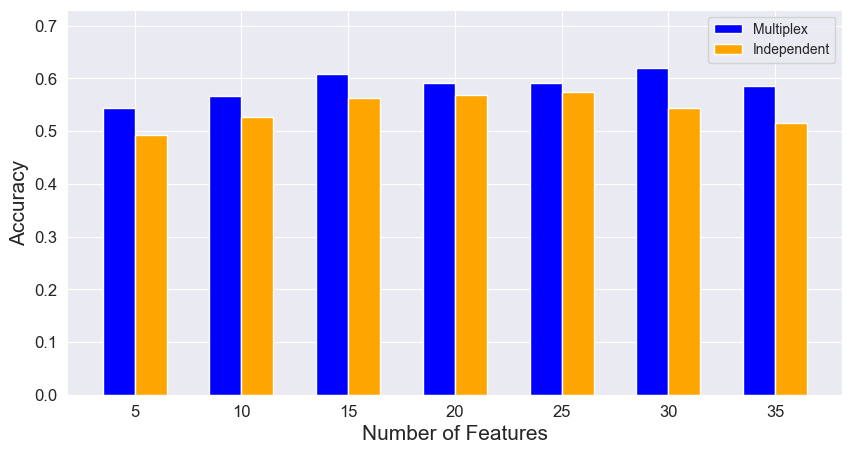

In [5]:
# Plotting accuracy scores as a function of number of features
plt.figure(figsize=(10, 5))
bar_width = 0.3
idx = np.arange(len(num_features_list))

plt.bar(idx, scores_multiplex, width=bar_width, color='blue', label='Multiplex')
plt.bar([i + bar_width for i in idx], scores_independent, width=bar_width, color='orange', label='Independent')

# Adding labels and title
plt.xlabel('Number of Features', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylim(0, 0.73)
#plt.title('Scores at Different Timesteps')
plt.xticks([i + bar_width/2 for i in idx], num_features_list)
plt.legend()

# Show the plot
plt.show()

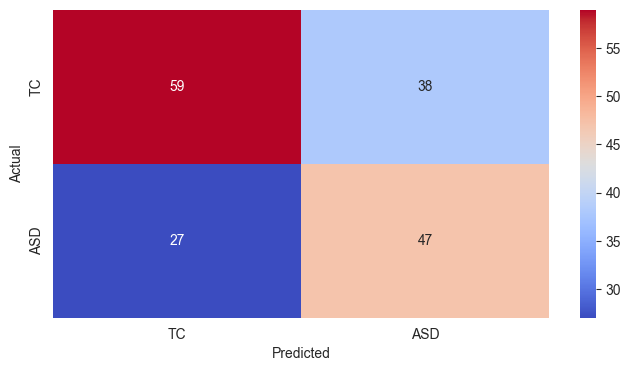

In [6]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix for multiplex and independent
max_multiplex_idx = np.argmax(scores_multiplex)
max_independent_idx = np.argmax(scores_independent)

best_conf_matrix_mult = conf_matrix_multiplex[max_multiplex_idx]
best_conf_matrix_indep = conf_matrix_independent[max_independent_idx]

class_labels = ['TC', 'ASD']

plt.figure(figsize=(8, 4))
sns.heatmap(best_conf_matrix_mult, annot=True, cmap="coolwarm", fmt="g", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted'); plt.ylabel('Actual')
#plt.title('Confusion Matrix Multiplex Features')
plt.show()

1
0


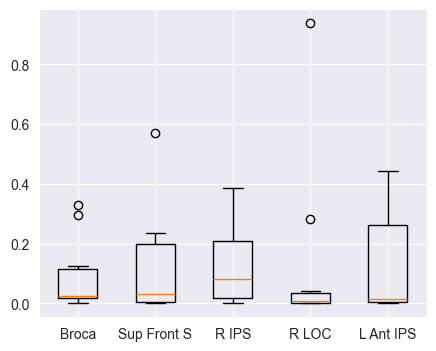

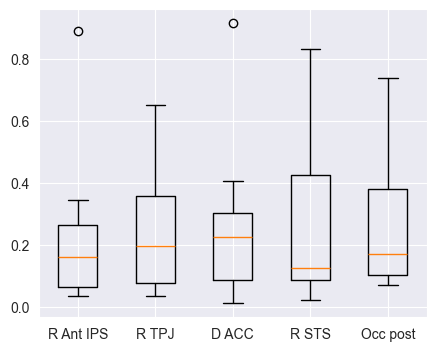

In [7]:
# plot the p-values for multiplex and independent
best_p_values_mult = p_values_multiplex[max_multiplex_idx]
best_p_values_indep = p_values_independent[max_independent_idx]

# take average over the 10 folds
best_p_values_mult = np.array(best_p_values_mult)
best_p_values_indep = np.array(best_p_values_indep)
best_p_values_mult = np.reshape(best_p_values_mult, (-1, 10))
best_p_values_indep = np.reshape(best_p_values_indep, (-1, 10))

best_p_values_mult_mean = np.mean(best_p_values_mult, axis=1)
best_p_values_indep_mean = np.mean(best_p_values_indep, axis=1)

# index of the 5 regions with the lowest p-values
smallest_pval_mult = np.argsort(best_p_values_mult_mean)[:5]
smallest_pval_indep = np.argsort(best_p_values_indep_mean)[:5]

subest_best_p_values_mult = best_p_values_mult[smallest_pval_mult, :]
subest_best_p_values_indep = best_p_values_indep[smallest_pval_indep, :]
subset_labels_mult = [labels[i] for i in smallest_pval_mult]
subset_labels_indep = [labels[i] for i in smallest_pval_indep]

plt.figure(figsize=(5,4))
plt.boxplot(subest_best_p_values_mult.T, labels=subset_labels_mult)

plt.figure(figsize=(5,4))
plt.boxplot(subest_best_p_values_indep.T, labels=subset_labels_indep)

# number of regions with p-value < 0.05
print(np.sum(best_p_values_mult_mean < 0.1))
print(np.sum(best_p_values_indep_mean < 0.1))

In [8]:
# computing statistical significance of centrality measures for both methods over the entire NYU dataset
import utils as ut
import numpy as np

X = np.load("X_NYU_0-100.npy")
y = np.load("y_NYU_0-100.npy")

X_ASD = X[y == 1]
X_TD = X[y == 0]

inter_layer_edges_weight = 0.3
interconnection_per_layer_pair = 20
r_pagerank = 0.85
num_features = num_ROIs

ut.multiplex_pagerank(X_ASD, num_ROIs, labels, inter_layer_edges_weight=inter_layer_edges_weight, interconnection_per_layer_pair=interconnection_per_layer_pair, save_name_pagerank="Z_multiplex_ASD_NYU_statistics.npy", show_best_features=False)
ut.multiplex_pagerank(X_TD, num_ROIs, labels, inter_layer_edges_weight=inter_layer_edges_weight, interconnection_per_layer_pair=interconnection_per_layer_pair, save_name_pagerank="Z_multiplex_TC_NYU_statistics.npy", show_best_features=False)
Z_ASD_mult = np.load("Z_multiplex_ASD_NYU_statistics.npy")
Z_TC_mult = np.load("Z_multiplex_TC_NYU_statistics.npy")

Z_indep, y, not_converged = ut.independent_pagerank(X, y, num_ROIs, labels, r_pagerank=r_pagerank, save_name="Z_independent_NYU_statistics.npy", show_best_features=False)
Z_ASD_indep = Z_indep[y == 1]
Z_TC_indep = Z_indep[y == 0]

# normalizing the centrality measures from multiplex network since they are depend on the number of layers
Z_ASD_mult = Z_ASD_mult / np.linalg.norm(Z_ASD_mult, axis=0)
Z_TC_mult = Z_TC_mult / np.linalg.norm(Z_TC_mult, axis=0)

min_pval_mult, pval_mult = ut.feature_selection(Z_ASD_mult, Z_TC_mult, num_ROIs, labels, num_features, show_best_features=False)
min_pval_indep, pval_indep = ut.feature_selection(Z_ASD_indep, Z_TC_indep, num_ROIs, labels, num_features, show_best_features=False)                                                     

Building supra-adjacency matrix:   0%|          | 0/74 [00:00<?, ?it/s]

Building supra-adjacency matrix:   0%|          | 0/98 [00:00<?, ?it/s]

Independent centrality measures:   0%|          | 0/172 [00:00<?, ?it/s]

/Users/abelrassat/opt/anaconda3/envs/cn_final_proj/lib/python3.11/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/abelrassat/opt/anaconda3/envs/cn_final_proj/lib/python3.11/site-packages/networkx/algorithms/link_analysis/pagerank_alg.py:496: RuntimeWarning: invalid value encountered in subtract
  err = np.absolute(x - xlast).sum()


Subjects for which Page Rank did not converge: [159] 
 Delete them manually from the dataset.


In [11]:
# index of the 5 regions with the lowest p-values
smallest_pval_mult = min_pval_mult[:30]
smallest_pval_indep = min_pval_indep[:30]

subest_best_p_values_mult = pval_mult[smallest_pval_mult]
subest_best_p_values_indep = pval_indep[smallest_pval_indep]
subset_labels_mult = [labels[i] for i in smallest_pval_mult]
subset_labels_indep = [labels[i] for i in smallest_pval_indep]

['L Aud', 'R Aud', 'Striate', 'L DMN', 'Med DMN', 'Front DMN', 'R DMN', 'Occ post', 'Motor', 'R DLPFC', 'R Front pol', 'R Par', 'R Post Temp', 'Basal', 'L Par', 'L DLPFC', 'L Front pol', 'L IPS', 'R IPS', 'L LOC', 'Vis', 'R LOC', 'D ACC', 'V ACC', 'R A Ins', 'L STS', 'R STS', 'L TPJ', 'Broca', 'Sup Front S', 'R TPJ', 'R Pars Op', 'Cereb', 'Dors PCC', 'L Ins', 'Cing', 'R Ins', 'L Ant IPS', 'R Ant IPS']


/Users/abelrassat/opt/anaconda3/envs/cn_final_proj/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


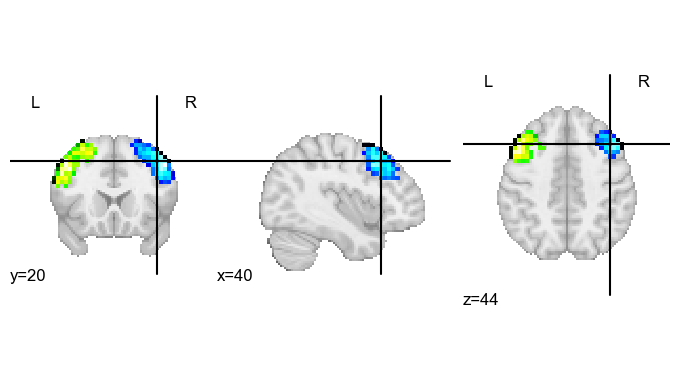

In [14]:
from nilearn import image, plotting
print(labels)

display = plotting.plot_stat_map(
    image.index_img(atlas_filename, smallest_pval_mult[1]),
    colorbar=False,
)

cmaps = [
    plotting.cm.black_blue,
    plotting.cm.black_green,
    plotting.cm.black_pink,
]
for index, cmap in zip(smallest_pval_mult[1:3], cmaps):
    display.add_overlay(image.index_img(atlas_filename, index), cmap=cmap)

plotting.show()

(40, 48, 35, 3)


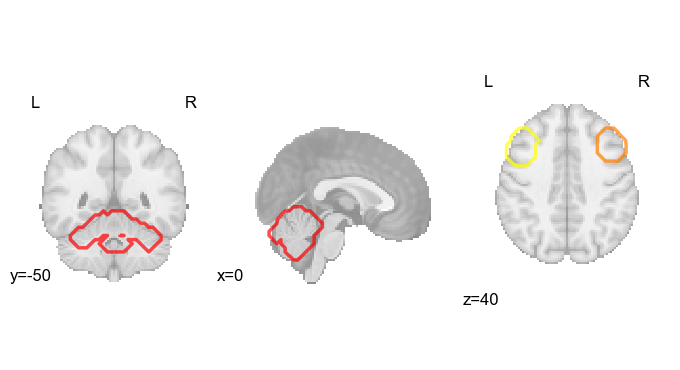

In [15]:
dmn_nodes = image.index_img(atlas_filename, smallest_pval_mult[:3])
# Note that dmn_node is now a 4D image
print(dmn_nodes.shape)

display = plotting.plot_prob_atlas(
    dmn_nodes, cut_coords=(0, -50, 40), dim=1, draw_cross=False, view_type="contours", cmap="autumn"
)
plotting.show()

(40, 48, 35, 3)


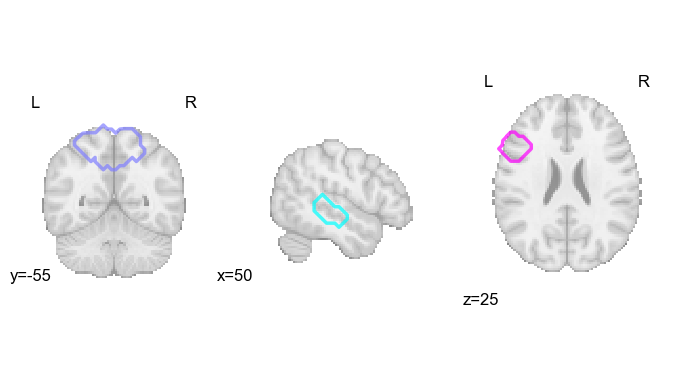

In [16]:
dmn_nodes = image.index_img(atlas_filename, smallest_pval_indep[:3])
# Note that dmn_node is now a 4D image
print(dmn_nodes.shape)

display = plotting.plot_prob_atlas(
    dmn_nodes, cut_coords=(50, -55, 25), dim=1, draw_cross=False, view_type="contours", cmap="cool"
)
plotting.show()